import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Load MNIST dataset from sklearn

In [56]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# from sklearn.datasets import fetch_mldata
# MNIST = fetch_mldata('MNIST original', data_home='./MNIST')

In [72]:
y = y.astype(np.int)
X=X/255
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, test_size=0.2)

In [59]:
print(y_train.shape)

(56000,)


Logistic regression

In [73]:
class SoftmaxRegression:
    '''
    Logistic regression for multi class
    '''
    
    
    def __init__(self, 
                 lr=0.0001, 
                 epoch=1,
                 tolerence=10e-8,
                 minibatchsize=30,
                 lambd=0):
        self.lr=lr
        self.epoch=epoch
        self.tolerence=tolerence
        self.minibatchsize=minibatchsize
        self.lambd = lambd
        
    def softmax(self,X,theta):
        z = X@theta
        z -= np.max(z)
        return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)
    
    # compute the grandient     
    def get_gradient(self, X, y, theta):
        n, _ = X.shape
        theta_wo_bias = theta.copy()
        theta_wo_bias[0, :] = 0
        
        grad = (-1 / n) * X.T@(y - self.softmax(X, theta)) + self.lambd * theta_wo_bias
        return grad
     
    #compute the loss
    def loss(self, X, y, theta):
        n, d = X.shape
        y_hat = self.softmax(X, theta)
 
        temp_theta = theta.copy()
        temp_theta[0, :] = 0 # Not including bias in regularization
       
        loss = (-1 / n) * np.sum(y * np.log(y_hat)) \
                + (self.lambd/2)*np.sum(temp_theta*temp_theta)

        return loss
    
    def one_hot_encode(self, y):
        '''
        one hot encode the target
        to be able to work with softmax
        '''
        n = len(y)
        # Turn y into one-hot-labels if number of classes is greater than 2
        y_encode = np.zeros((n, self.nb_classes))
        y_encode[range(n), y] = 1 #numpy advanced indexing
        y = y_encode
        return y
   
    #mini batch gradient descent        
    def fit(self,X,y):
        '''
        This method take tha data, 
        use minibactch gradient descent to update the weight
        and compute the coresponding cost
        '''
        #make a copy of our data
        X_copy=X.copy()
        y_copy=y.copy()
        self.classes = np.unique(y_copy)
        self.nb_classes = len(self.classes)
        
         #add the intercept column
        intercept=np.ones((X_copy.shape[0],1))
        X_copy=np.concatenate((intercept,X_copy),axis=1)
        
        
        #initialise the weight
        self.theta=np.zeros((X_copy.shape[1], self.nb_classes))
        
        # One-hot encode y
        y_copy = self.one_hot_encode(y_copy)
       
        diff=1
        current_iter=1
        #number of minibacth
        minibatch = int(len(X_copy)/self.minibatchsize)
        while (diff >= self.tolerence) and (current_iter<self.epoch) :
            prev_theta=self.theta.copy()
            random_vector=np.random.permutation(X_copy.shape[0])
            X_cop=X_copy[random_vector]
            y_cop=y_copy[random_vector]
            for j in range(minibatch):
                X_=X_cop[j*self.minibatchsize:(j+1)*self.minibatchsize]
                y_=y_cop[j*self.minibatchsize:(j+1)*self.minibatchsize]
                #compute the gradient
                grad = self.get_gradient(X_, y_, self.theta)
                #update the weight
                self.theta = self.theta - self.lr*grad 
            cur_theta=self.theta.copy()
            diff=np.linalg.norm(prev_theta - cur_theta)
            current_iter+=1
            #print('the loss function is ',self.loss(X_,y_,self.theta))

    def predict_proba(self, X):
        """
        Returns probability of predictions.
        """
        X_copy = X.copy()
        intercept=np.ones((X_copy.shape[0],1))
        X_copy=np.concatenate((intercept,X_copy), axis=1)

        return self.softmax(X_copy, self.theta) 
    
    def predict(self, X):
        '''
            gives the prediction using the softmax function
        '''
        prob = self.predict_proba(X)
        y_predict = np.argmax(prob, axis=1)
        return y_predict     
    

In [74]:
logisticReg = SoftmaxRegression(
                            lr=0.001, 
                             epoch=20,
                             tolerence=10e-8,
                             minibatchsize=30,
                             lambd=0
                            )

In [75]:
logisticReg.fit(X_train,y_train)

In [76]:
predict=logisticReg.predict(X_test)

In [79]:
(np.sum(predict==y_test)/len(y_test))*100

88.94285714285715

In [78]:
predict[:100]

array([8, 4, 5, 7, 7, 0, 6, 2, 7, 4, 3, 9, 7, 8, 2, 5, 9, 1, 7, 8, 0, 0,
       0, 3, 6, 3, 6, 1, 6, 9, 7, 6, 0, 8, 5, 5, 2, 9, 1, 6, 4, 9, 4, 7,
       4, 5, 8, 7, 3, 9, 2, 0, 6, 8, 5, 3, 1, 4, 0, 7, 1, 7, 5, 3, 9, 5,
       7, 9, 6, 0, 1, 7, 3, 0, 4, 3, 4, 2, 6, 6, 6, 6, 8, 2, 2, 1, 5, 3,
       8, 8, 7, 5, 1, 8, 2, 0, 8, 7, 3, 0])

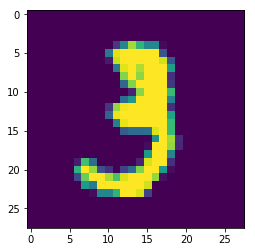

In [84]:
plt.imshow(X[10].reshape(28,28))